In [1]:
import duckdb
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config

In [2]:
def fetch_rushes():
	pass

In [3]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"down",
	"goal_to_go",
	"ydstogo",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	#'spread_line',
	#'total_line',
]

x_cols = game_context_cols +rusher_stat_cols + ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'first_down', 'touchdown'] #+ ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [4]:
len(x_cols)

13

In [5]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,
	case when pbp.run_gap = 'end' then 2
		when pbp.run_gap = 'tackle' then 1
		when pbp.run_gap = 'guard' then 0  else 1 end as run_gap_encoded,
	case when pbp.down = 1 then '1' else 0 end as is_first_down,
	case when pbp.down = 2 then '1' else 0 end as is_second_down,
	case when pbp.down = 3 then '1' else 0 end as is_third_down,
	case when pbp.down = 4 then '1' else 0 end as is_fourth_down,
                     pbp.first_down, pbp.touchdown,
	{', '.join(('pbp.' + x for x in game_context_cols))},
	{', '.join(('t.' + x for x in team_stat_cols))},
	{', '.join(('o.' + x for x in opp_stat_cols))},
	{', '.join(('r.' + x for x in rusher_stat_cols))},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.rusher_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
    and pbp.penalty = 0
    and pbp.fumble = 0
""")

In [6]:
rushes[rusher_stat_cols] = rushes[rusher_stat_cols].fillna(0)
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [ ]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
	def __init__(self, n_hidden):
		super().__init__()
		self.layer = nn.Sequential(
			nn.Linear(n_hidden, n_hidden),
			nn.LayerNorm(n_hidden),
			nn.ReLU()
		)
	
	def forward(self, x):
		return x + self.layer(x)

class masked_model(nn.Module):
	def __init__(self, n_in=11, n_out=109, n_hidden=50):
		super(masked_model, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		)
		self.output_layer  = nn.Linear(n_hidden, n_out)
		self.td_head = nn.Linear(n_hidden, 1)
	def forward(self, x):

		
		# Extract the feature to pass to the final layer (e.g., the first feature)
		yardline = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
		yard_values = torch.arange(0, self.n_out, device=x.device).float().unsqueeze(0)
		mask = (yard_values <= yardline + 30).float()
		td_bin = (yardline + 30).long().squeeze(1)

		x = self.main_layers(x)
		logits = self.output_layer(x)
		td_logits = self.td_head(x)
		batch_indices = torch.arange(logits.size(0), device=logits.device)
		logits[batch_indices, td_bin] = logits[batch_indices, td_bin] + td_logits.squeeze(1)
		print()
        

		masked_logits = logits + (mask - 1) * 1e9

		return masked_logits

In [89]:
X = rushes[x_cols]
y = rushes['yards_shifted']
X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [90]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

def get_sample(num_samples):
	idx = np.random.randint(0,len(X_tensor), num_samples)
	return X_tensor[idx]

get_sample(2)

model = masked_model(
	n_in=len(x_cols),
	n_out=130,
	n_hidden=64,
)
			# numerical value
c = get_sample(1)
print(c.shape)
pred = model(c)

torch.Size([1, 13])


In [56]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
    
    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [123]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	y = torch.tensor(y,dtype=torch.long).to(device)
	# Define the model, loss function, and optimizer

	X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
	if not model:
		model = masked_model(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	criterion = FocalLoss(gamma=3.0) # Suitable for classification
	#criterion = nn.CrossEntropyLoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.009)

	num_samples = X_tensor.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices

	Xtr = X_tensor[train_indices].to(device)
	Xtst = X_tensor[test_indices].to(device)
	train_y = y[train_indices].to(device)
	test_y =  y[test_indices].to(device)

	# Training loop
	epochs = epochs

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)
			probs_mean = (torch.arange(0,130, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) * 1.5
			loss = classifier_loss + mean_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()

		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/len(Xtr):.4f}, MSE Loss: {epoch_mean_loss/len(Xtr):.4f}")

		# Evaluation on the test set
		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)  # Shape: [num_samples, 100]
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

		test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
	plt.hist(test_preds, alpha=0.5, color='r')
	plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
	return model

Epoch 1/7, Classifier Loss: 0.2169, MSE Loss: 0.4614
Test Loss: 28.1153, Test Accuracy: 0.1217
Epoch 2/7, Classifier Loss: 0.1170, MSE Loss: 0.3638
Test Loss: 9.7693, Test Accuracy: 0.1316
Epoch 3/7, Classifier Loss: 0.0661, MSE Loss: 0.2784
Test Loss: 5.0409, Test Accuracy: 0.1475
Epoch 4/7, Classifier Loss: 0.0445, MSE Loss: 0.2679
Test Loss: 6.5860, Test Accuracy: 0.1508
Epoch 5/7, Classifier Loss: 0.0390, MSE Loss: 0.2703
Test Loss: 13.1320, Test Accuracy: 0.1339
Epoch 6/7, Classifier Loss: 0.0378, MSE Loss: 0.2670
Test Loss: 3.5039, Test Accuracy: 0.1544
Epoch 7/7, Classifier Loss: 0.0302, MSE Loss: 0.2637
Test Loss: 3.5821, Test Accuracy: 0.1496


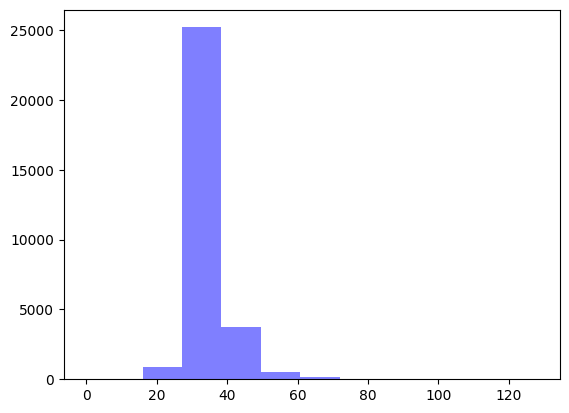

In [124]:
rush_yards_model = train_model(X,y, n_in=len(x_cols), n_out=130, n_hidden = 512, epochs=7)

#Epoch 10/10, Classifier Loss: 0.0408, MSE Loss: 0.3164
#Epoch 10/10, Classifier Loss: 0.0405, MSE Loss: 0.2760 with touchdown head thing
#Epoch 10/10, Classifier Loss: 0.0323, MSE Loss: 0.2484 ? but this was so busted idk

In [125]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

Actual mean: 4.54, Model mean: 3.91
number of datapoints: 1349


(-20.0, 37.0)

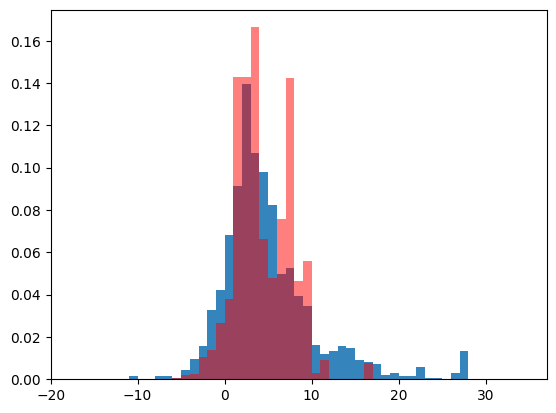

In [126]:
def sample_model_yardline(yard, down):
	inp = rushes.loc[(rushes.yardline_100==yard), x_cols]
	y = rushes.loc[ (rushes.yardline_100==yard), 'yards_gained']

	inp =  torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).mean(0).detach().numpy()
	exp_logits = np.exp(out - np.max(out))
	probs = exp_logits / exp_logits.sum()
	plt.hist(y, range(-30,100), density=True, alpha=0.9)

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 30) @ probs  # adjust if 0th class = -30
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 27
down = 1
plt.bar(range(-30 ,100 ), sample_model_yardline(yard, down), width=1, 
        alpha=0.5, align="edge", label="Bar Chart", color='r')
plt.xlim(-20,yard+10)